A poor idea followed by a better one.

Here, we explore the use of non-Bspline basis functions for estimating underlying signals with noise.

- exponential "basis" functions
- fourier basis functions

For the fourier basis, we examine the effect of tikhonov and smoothing regularisations
(not 100% about the implementation of the smoothing reg. but seems consistent with the tikh. implementation)

In [173]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

In [15]:
def expn(t, k, T):
    return (np.exp(k * t/T) - 1) / (np.exp(k) - 1)

In [16]:
T = 2

basis = lambda t: [expn(t, ki, T) for ki in range(-4, 5)]

In [17]:
tx = np.linspace(0, 2, 100)

bys = basis(tx)

C:\Users\dwu\AppData\Local\Temp\ipykernel_12608\2957065174.py:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.exp(k * t/T) - 1) / (np.exp(k) - 1)


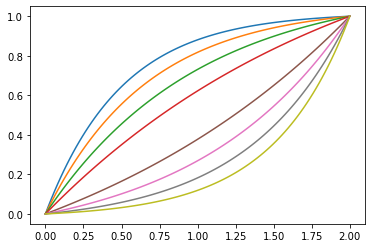

In [18]:
plt.plot(tx, np.vstack(bys).T)

In [19]:
import casadi as ca

In [20]:
t = ca.SX.sym('t')

In [149]:
N = 20
basis_01 = [1] + [fx(2*ca.pi*n*t) for fx in (ca.sin, ca.cos) for n in range(1, N+1)]

In [150]:
bas01_fn = ca.Function('bas01', [t], basis_01)

In [151]:
tx = np.linspace(0, 1, 400)

by = bas01_fn.map(400)(tx)

In [152]:
bM = ca.vcat(by).T

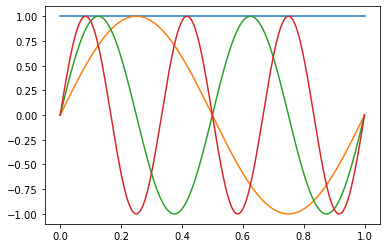

In [193]:
plt.plot(tx, ca.vcat(by).T[:,:4]);

In [125]:
datay = np.sin(2.001*np.pi*tx) + np.random.randn(*tx.shape)*0.15

In [126]:
ca.pinv(bM) @ datay

DM([0.0031626, 0.993759, -0.0102081, -0.00231605, 0.0166027, 0.00777974, -0.00806099, 0.00331275, -0.00485875, -0.000158658, 0.013143, 0.00514749, -0.010933, -0.00050286, -0.00505671, 0.00728764, -0.0107537, -0.00430806, 0.00139575, 0.0139814, -0.00160538, 0.0065465, -0.0195424, 0.00676781, 0.0167622, 0.0110073, 0.00258337, 0.00609377, 0.00811944, -0.00938327, 0.00407533, -0.0122193, 0.0172631, 0.00625511, 0.0142139, -0.00677696, 0.0071881, -0.00338921, -0.0146264, 0.00278523, 0.0045251, 0.0131256, -0.0120745, 0.0117859, 0.00633687, -0.0240888, 0.0179373, -0.0163616, 0.0121734, 0.00219053, -0.00414327, 0.00939419, -0.00768145, -0.013776, -0.0238682, -0.0113351, -0.0138756, -0.0180963, -0.0101068, 0.0218097, -0.00549113, 0.00745793, -0.00418434, -0.00457761, -0.00364754, 0.00704551, -0.0080543, 0.0101074, -0.0074066, -0.0111108, -0.0103584, 0.0377431, 0.0013919, 0.00817351, 0.00526947, 3.92355e-05, -0.0140823, 0.0105819, -0.00158668, -0.0100535, 0.00312301])

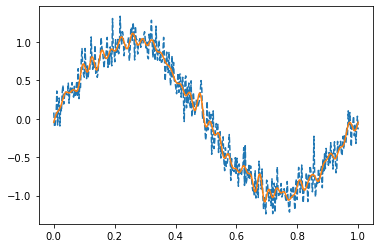

In [127]:
plt.plot(tx, datay, '--')
plt.plot(tx, bM @ (ca.pinv(bM) @ datay), '-')

In [128]:
reg_f = lambda a: ca.inv(bM.T @ bM + ca.diag([a]*(2*N+1)))@bM.T @ datay

In [129]:
dist = lambda c: float(ca.sumsqr((bM @ c) - datay))
regd = lambda c: float(ca.sumsqr(c))

In [139]:
reg_f_vals = [reg_f(a) for a in np.logspace(-2, 3, base=10, num=41)]

Classic L-curve plot

Text(0, 0.5, 'f')

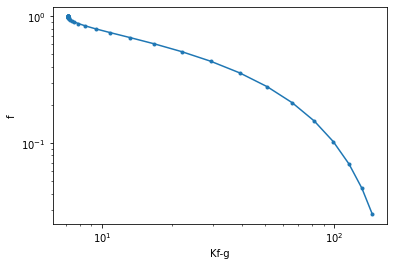

In [140]:
plt.loglog([dist(v) for v in reg_f_vals], [regd(v) for v in reg_f_vals], '.-')
plt.xlabel('Kf-g')
plt.ylabel('f')

Doesn't look like a classic L-curve penalty actually removes wiggles from a fourier basis - the cluster of points in the top-right are overfits to data, but the "bend" happens there, suggesting the "optimal" reg. param selection is for overfit of data.

In [145]:
datay2 = np.exp(tx * 5) + np.random.randn(*tx.shape)*10

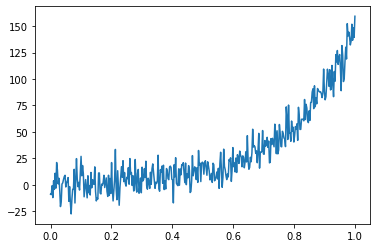

In [146]:
plt.plot(tx, datay2)

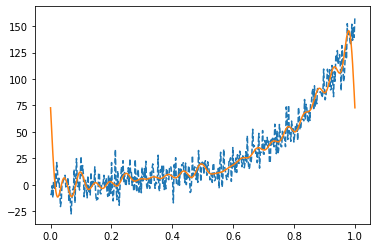

In [153]:
plt.plot(tx, datay2, '--')
plt.plot(tx, bM @ (ca.pinv(bM) @ datay2), '-')

In [158]:
d2phi_sym = [0] + [-(4*ca.pi**2*n**2)*fx(2*ca.pi*n*t) for fx in (ca.sin, ca.cos) for n in range(1, N+1)]
d2phi_fn = ca.Function('d2phi', [t], d2phi_sym)
d2y = d2phi_fn.map(400)(tx)
d2phi = ca.vcat(d2y).T

In [159]:
reg_oper_d2 = lambda a: ca.inv(bM.T @ bM + a*(d2phi.T @ d2phi))@bM.T

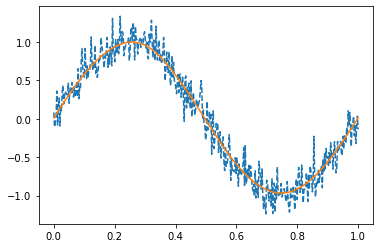

In [169]:
plt.plot(tx, datay, '--')
plt.plot(tx, bM @ (reg_oper_d2(1e-5) @ datay))

Here, we used a smoothing operator regularisation.
This seems to remove spurious oscillations from the solution.

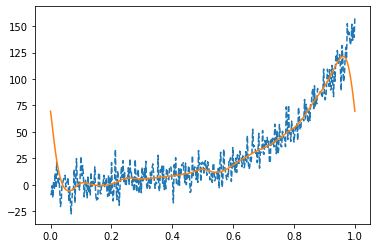

In [171]:
plt.plot(tx, datay2, '--')
plt.plot(tx, bM @ (reg_oper_d2(1e-7) @ datay2))

On the exponential growth 'data', we see a problem of the fourier basis is that it assumes the data is periodic, so we see the endpoints acting "weirdly"

In [172]:
def single_jump_model(t, y, p):
    a, r = y[:2]
    *ps, g = p[:9]
    k1 = p[0]*ca.exp(p[1]*V)
    k2 = p[2]*ca.exp(-p[3]*V)
    k3 = p[4]*ca.exp(p[5]*V)
    k4 = p[6]*ca.exp(-p[7]*V)
    
    a_inf = k1/(k1+k2)
    tau_a = 1/(k1+k2)
    r_inf = k4/(k3+k4)
    tau_r = 1/(k3+k4)
    
    
    da = (a_inf - a)/tau_a
    dr = (r_inf - r)/tau_r
    
    return [
        da, 
        dr
    ]


def obsv(t, y, p):
    # I
    a, r = y[:2]
    *ps, g = p[:9]
    return g * a * r * (V - EK)

In [174]:
V = 20
EK = -80
tlim = [0, 2000]
y0 = [ # a, r
    0, 1]
p_true = [2.26e-4, 0.0699, 3.45e-5, 0.05462, 0.0873, 8.91e-3, 5.15e-3, 0.03158, 0.1524]

ar_sol = integrate.solve_ivp(single_jump_model, tlim, y0, args=[p_true], dense_output=True)

Text(0.5, 0, 't (ms)')

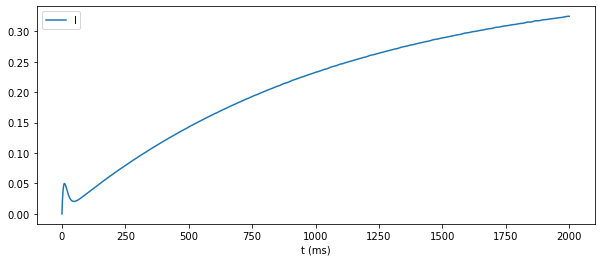

In [176]:
ts = np.linspace(*tlim, tlim[-1])

plt.figure(figsize=[10, 4])
plt.plot(ts, obsv(ts, ar_sol.sol(ts), p_true))
plt.legend('I')
plt.xlabel('t (ms)')

In [178]:
data_t = np.linspace(*tlim, 400)
truth = obsv(data_t, ar_sol.sol(data_t), p_true)
y_synth = truth * (1 + 0.05*np.random.randn(*truth.shape))

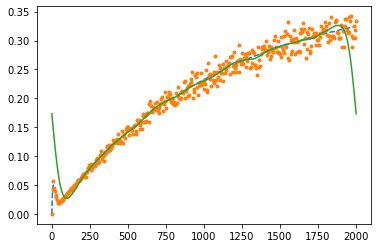

In [180]:
plt.plot(data_t, truth, '--')
plt.plot(data_t, y_synth, '.')
plt.plot(data_t, bM @ (reg_oper_d2(1e-7) @ y_synth))

similar problem when using fourier basis on simulated single-step ion channel data.

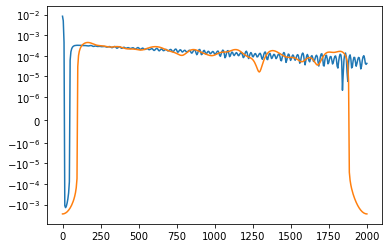

In [189]:
plt.plot(data_t, np.gradient(truth, data_t))
plt.plot(data_t, np.gradient((bM @ (reg_oper_d2(1e-7) @ y_synth)).toarray().flatten(), data_t))

plt.yscale('symlog', linthresh=1e-6)

There is overall decent agreement at the derivative level, comparing a finite-diff version of the truth (blue) with the spline.

Though those end effects might be a bit killer.